# Telco Churn prediction using ANN

The notebook uses Telco customer churn dataset which can be accessed [here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

The dataset consists of 7043 rows and 21 columns.

<b>Task:</b> predict customer churn based on features provided

## Importing some packages

Installing keras tuner

In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU, ReLU
from tensorflow.keras.layers import Dropout

import keras_tuner as kt

## Loading the data

In [3]:
df = pd.read_csv('TelcoCustomerChurn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory data analysis (EDA)

Checking for missing values in the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Showing summary for categorical columns

In [5]:
df.describe(include=['object'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


As TotalCharges is considered as an object, but, in reality, it is a numeric feature, let's create a function which will convert TotalCharges into float type and save any non numeric value in missing_value_list.

In [6]:
missing_value_list = []

def get_num_from_str(x):

    global missing_value_list

    try:
        return float(x)
    except:
        missing_value_list.append(x)
        return np.nan

Converting TotalCharges into float type and filling missing values with median

In [7]:
df['TotalCharges'] = df['TotalCharges'].apply(get_num_from_str)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

missing_value_list

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

Showing summary for numeric columns

In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Separating names of categorical and numeric columns in different lists

In [9]:
cat_col_list = list(df.select_dtypes(include=['object']).columns)
num_col_list = [col for col in df.columns if col not in cat_col_list] 
cat_col_list.remove('customerID')
df.drop(columns='customerID', inplace=True)

print(f'Categorical columns: {cat_col_list}')
print(f'Numerical columns: {num_col_list}')

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


## Feature Engineering

Let's apply one hot encoding to categorical columns.

In [10]:
cat_df = pd.get_dummies(df[cat_col_list], drop_first=True)
df.drop(columns=cat_col_list, inplace=True)
df = pd.concat([df, cat_df], axis=1)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


Splitting data into features and target

In [11]:
y = df.pop('Churn_Yes')
X = df.copy()

del df

Checking for distribution of the target 

In [12]:
y.value_counts()

0    5174
1    1869
Name: Churn_Yes, dtype: int64

Splitting data into training, validation, testing sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Checking target distribution in the derived sets

In [14]:
y_train.value_counts(normalize=True)

0    0.734635
1    0.265365
Name: Churn_Yes, dtype: float64

In [15]:
y_valid.value_counts(normalize=True)

0    0.734694
1    0.265306
Name: Churn_Yes, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.734564
1    0.265436
Name: Churn_Yes, dtype: float64

Applying standard scaler to features and converting target dataframes into numpy arrays

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

## Model building

### Without dropout

Creating a model without dropout

In [18]:
clf = Sequential()
clf.add(Dense(units=10, input_shape=(X_train.shape[1], ), activation='relu'))
clf.add(Dense(units=10, activation='relu'))
clf.add(Dense(units=10, activation='relu'))
clf.add(Dense(units=1, activation='sigmoid'))

clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [19]:
import tensorflow

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
clf.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    # min_delta=0.0001,
    # verbose=1,
    # mode='auto',
    # baseline=None,
    # restore_best_weights=False
)

model_history = clf.fit(
    X_train, y_train, 
    validation_data=[X_valid, y_valid], 
    batch_size=10, 
    epochs=100, 
    callbacks=early_stopping
)

Epoch 1/100
451/451 [==============================] - 8s 5ms/step - loss: 0.4596 - accuracy: 0.7675 - val_loss: 0.4307 - val_accuracy: 0.8092
Epoch 2/100
451/451 [==============================] - 3s 6ms/step - loss: 0.4343 - accuracy: 0.7961 - val_loss: 0.4530 - val_accuracy: 0.7941
Epoch 3/100
451/451 [==============================] - 3s 7ms/step - loss: 0.4312 - accuracy: 0.7952 - val_loss: 0.4465 - val_accuracy: 0.8039
Epoch 4/100
451/451 [==============================] - 3s 7ms/step - loss: 0.4291 - accuracy: 0.7974 - val_loss: 0.4594 - val_accuracy: 0.7587
Epoch 5/100
451/451 [==============================] - 4s 9ms/step - loss: 0.4278 - accuracy: 0.7954 - val_loss: 0.4307 - val_accuracy: 0.7853
Epoch 6/100
451/451 [==============================] - 3s 8ms/step - loss: 0.4214 - accuracy: 0.7970 - val_loss: 0.4448 - val_accuracy: 0.7862
Epoch 7/100
451/451 [==============================] - 3s 7ms/step - loss: 0.4182 - accuracy: 0.8021 - val_loss: 0.4339 - val_accuracy: 0.7897

In [20]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Showing accuracy score and loss by epoch

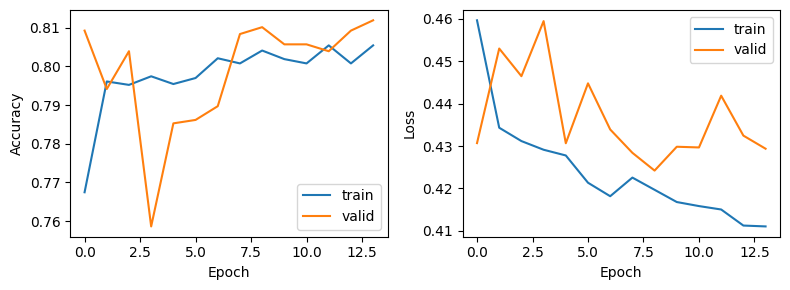

In [21]:
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)

plt.plot(
    np.arange(len(model_history.history['accuracy'])), 
    model_history.history['accuracy'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_accuracy'])), 
    model_history.history['val_accuracy'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)

plt.plot(
    np.arange(len(model_history.history['loss'])), 
    model_history.history['loss'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_loss'])), 
    model_history.history['val_loss'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Creating the confusion matrix

45/45 [==============================] - 0s 1ms/step


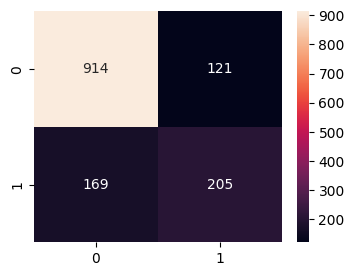

In [22]:
y_test_pred = clf.predict(X_test)
y_test_pred = (y_test_pred>0.5)

cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d');

Showing the classification report

In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.63      0.55      0.59       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



Showing accuracy score for testing set

In [24]:
score = accuracy_score(y_test, y_test_pred)
score

0.794180269694819

### With dropout

Creating a model with dropout

In [25]:
clf = Sequential()
clf.add(Dense(units=10, input_shape=(X_train.shape[1], ), activation='relu'))
clf.add(Dropout(0.2))
clf.add(Dense(units=10, activation='relu'))
clf.add(Dropout(0.2))
clf.add(Dense(units=10, activation='relu'))
clf.add(Dropout(0.2))
clf.add(Dense(units=1, activation='sigmoid'))

clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [26]:
import tensorflow

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
clf.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    # min_delta=0.0001,
    # verbose=1,
    # mode='auto',
    # baseline=None,
    # restore_best_weights=False
)

model_history = clf.fit(
    X_train, y_train, 
    validation_data=[X_valid, y_valid], 
    batch_size=10, 
    epochs=100, 
    callbacks=early_stopping
)

Epoch 1/100
451/451 [==============================] - 4s 4ms/step - loss: 0.5016 - accuracy: 0.7542 - val_loss: 0.4567 - val_accuracy: 0.7986
Epoch 2/100
451/451 [==============================] - 2s 4ms/step - loss: 0.4577 - accuracy: 0.7812 - val_loss: 0.4530 - val_accuracy: 0.7436
Epoch 3/100
451/451 [==============================] - 3s 6ms/step - loss: 0.4576 - accuracy: 0.7757 - val_loss: 0.4484 - val_accuracy: 0.7382
Epoch 4/100
451/451 [==============================] - 3s 6ms/step - loss: 0.4432 - accuracy: 0.7783 - val_loss: 0.4407 - val_accuracy: 0.7897
Epoch 5/100
451/451 [==============================] - 2s 5ms/step - loss: 0.4492 - accuracy: 0.7777 - val_loss: 0.4390 - val_accuracy: 0.7728
Epoch 6/100
451/451 [==============================] - 2s 4ms/step - loss: 0.4395 - accuracy: 0.7812 - val_loss: 0.4429 - val_accuracy: 0.7817
Epoch 7/100
451/451 [==============================] - 2s 4ms/step - loss: 0.4523 - accuracy: 0.7823 - val_loss: 0.4377 - val_accuracy: 0.7941

Showing accuracy and loss by epoch

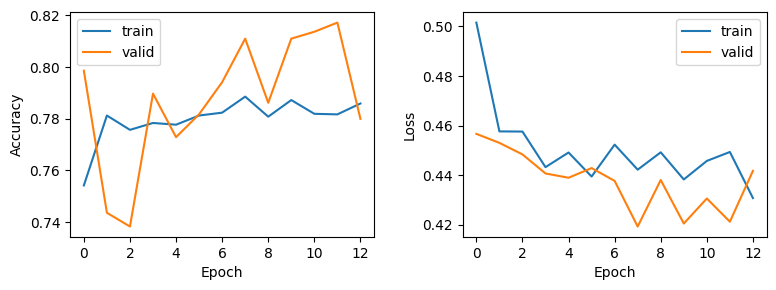

In [27]:
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)

plt.plot(
    np.arange(len(model_history.history['accuracy'])), 
    model_history.history['accuracy'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_accuracy'])), 
    model_history.history['val_accuracy'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)

plt.plot(
    np.arange(len(model_history.history['loss'])), 
    model_history.history['loss'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_loss'])), 
    model_history.history['val_loss'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Showing the confusion matrix

45/45 [==============================] - 0s 1ms/step


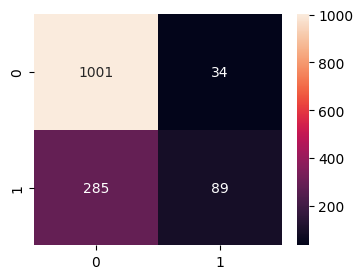

In [28]:
y_test_pred = clf.predict(X_test)
y_test_pred = (y_test_pred>0.5)

cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d');

Showing the classification report

In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1035
           1       0.72      0.24      0.36       374

    accuracy                           0.77      1409
   macro avg       0.75      0.60      0.61      1409
weighted avg       0.76      0.77      0.73      1409



Showing accuracy for test set

In [30]:
score = accuracy_score(y_test, y_test_pred)
score

0.7735982966643009

### Using Keras tuner

Creating model builder function

In [31]:
def model_builder(hp):

    model = Sequential()

    for i in range(hp.Int('layers', 1, 10)):
        if i == 0:
            model.add(
                Dense(
                    units=hp.Int(f'units_{i}', min_value=10, max_value=532, step=32),
                    input_shape=(X_train.shape[1], ),
                    activation='relu'
                )
            )
        else:
            model.add(
                Dense(
                    units=hp.Int(f'units_{i}', min_value=10, max_value=532, step=32),
                    activation='relu'
                )
            )
        model.add(Dropout(hp.Choice(f'dropout_{i}', [0.0, 0.2, 0.25, 0.3, 0.5, 0.8])))
    
    model.add(Dense(1, activation='sigmoid'))

    opt = tensorflow.keras.optimizers.Adam(
        learning_rate=hp.Choice(
            'learning_rate', 
             [0.0001, 0.0003, 0.01, 0.03, 0.1, 0.3, 1.0]
        )
    )

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

Tuning the parameters

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner',
    project_name='telco_churn'
)

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    # min_delta=0.0001,
    # verbose=1,
    # mode='auto',
    # baseline=None,
    # restore_best_weights=False
)

tuner.search(
    X_train, y_train, 
    validation_data=[X_valid, y_valid],
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

In [35]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete!!!')
print(f"The optimal number of layers is {best_hps.get('layers')}.")
for i in range(int(best_hps.get('layers'))):
    print(f"The optimal number of neurons for layer {i+1} is {best_hps.get(f'units_{i}')}.")
    print(f"The optimal value of dropout for layer {i+1} is {best_hps.get(f'dropout_{i}')}.")
print(f"The optimal learning rate is {best_hps.get('learning_rate')}.")

The hyperparameter search is complete!!!
The optimal number of layers is 2.
The optimal number of neurons for layer 1 is 234.
The optimal value of dropout for layer 1 is 0.5.
The optimal number of neurons for layer 2 is 330.
The optimal value of dropout for layer 2 is 0.0.
The optimal learning rate is 0.01.


Selecting the optimal number epochs

In [36]:
model = tuner.hypermodel.build(best_hps)

model_history = model.fit(
    X_train, y_train,
    validation_data=[X_valid, y_valid],
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

val_acc_per_epoch = model_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
141/141 [==============================] - 3s 6ms/step - loss: 0.4671 - accuracy: 0.7817 - val_loss: 0.4375 - val_accuracy: 0.8012
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4441 - accuracy: 0.7837 - val_loss: 0.4388 - val_accuracy: 0.7595
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 0.4464 - accuracy: 0.7912 - val_loss: 0.4281 - val_accuracy: 0.8057
Epoch 4/100
141/141 [==============================] - 1s 5ms/step - loss: 0.4406 - accuracy: 0.7894 - val_loss: 0.4381 - val_accuracy: 0.8057
Epoch 5/100
141/141 [==============================] - 1s 6ms/step - loss: 0.4411 - accuracy: 0.7905 - val_loss: 0.4323 - val_accuracy: 0.8181
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.4373 - accuracy: 0.7934 - val_loss: 0.4218 - val_accuracy: 0.8146
Epoch 7/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4296 - accuracy: 0.8003 - val_loss: 0.4256 - val_accuracy: 0.8101

Training the tuned model

In [37]:
hypermodel = tuner.hypermodel.build(best_hps)

model_history = hypermodel.fit(
    X_train, y_train,
    validation_data=[X_valid, y_valid],
    epochs=best_epoch,
    batch_size=32,
    # callbacks=[early_stopping]
)

Epoch 1/5
141/141 [==============================] - 2s 8ms/step - loss: 0.4863 - accuracy: 0.7677 - val_loss: 0.4271 - val_accuracy: 0.8075
Epoch 2/5
141/141 [==============================] - 1s 6ms/step - loss: 0.4397 - accuracy: 0.7928 - val_loss: 0.4509 - val_accuracy: 0.8004
Epoch 3/5
141/141 [==============================] - 1s 5ms/step - loss: 0.4362 - accuracy: 0.7957 - val_loss: 0.4301 - val_accuracy: 0.8030
Epoch 4/5
141/141 [==============================] - 1s 4ms/step - loss: 0.4393 - accuracy: 0.7921 - val_loss: 0.4303 - val_accuracy: 0.8128
Epoch 5/5
141/141 [==============================] - 1s 4ms/step - loss: 0.4335 - accuracy: 0.7894 - val_loss: 0.4275 - val_accuracy: 0.8146


Showing the accuracy and loss

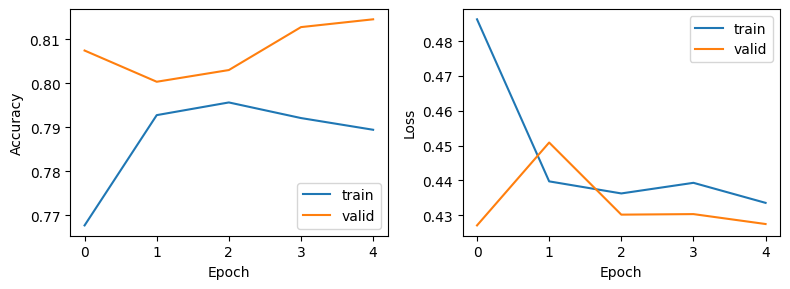

In [38]:
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)

plt.plot(
    np.arange(len(model_history.history['accuracy'])), 
    model_history.history['accuracy'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_accuracy'])), 
    model_history.history['val_accuracy'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)

plt.plot(
    np.arange(len(model_history.history['loss'])), 
    model_history.history['loss'], 
    label='train'
)
plt.plot(
    np.arange(len(model_history.history['val_loss'])), 
    model_history.history['val_loss'], 
    label='valid'
)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Creating the confusion matrix

45/45 [==============================] - 0s 1ms/step


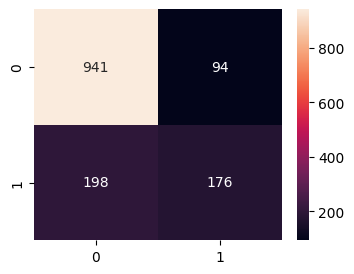

In [39]:
y_test_pred = hypermodel.predict(X_test)
y_test_pred = (y_test_pred>0.5)

cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d');

Showing the classification report

In [40]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



Showing the accuracy of test set

In [41]:
score = accuracy_score(y_test, y_test_pred)
score

0.7927608232789212